In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np
import matplotlib.pyplot as plt

**Đọc dataset và chuẩn hóa tên các thuộc tính trong bộ dữ liệu**

In [2]:
label_encoder = LabelEncoder()
dataframe = pd.read_csv('./../../datasets/Dataset_WOD_2.csv')
dataframe.dropna(inplace=True)
dataframe.rename(columns=lambda x: x.lower(), inplace=True)

dataframe['label'] = label_encoder.fit_transform(dataframe['label'])

**Chuẩn hóa thuộc tính theo phân phối chuẩn**

In [3]:
x = dataframe.drop(columns=['id', 'label'], axis=1)
y = dataframe['label']
scaler = StandardScaler().fit(x)
x = pd.DataFrame(scaler.transform(x))

**Cross-validation huấn luyện và đánh giá mô hình**

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgboost_model = XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error", "error@0.6"])
    xgboost_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

    y_pred = xgboost_model.predict(x_test)

    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

**Tính toán các giá trị trung bình, độ lệch chuẩn của kết quả kiểm tra**

In [5]:
average_accuracy = sum(accuracy_list) / len(accuracy_list)
average_precision = sum(precision_list) / len(precision_list)
average_recall = sum(recall_list) / len(recall_list)
average_f1 = sum(f1_list) / len(f1_list)

std_accuracy = np.std(accuracy_list)
std_precision = np.std(precision_list)
std_recall = np.std(recall_list)
std_f1 = np.std(f1_list)

In [6]:
print(f'''Average - Std Accuracy: {average_accuracy} - {std_accuracy}''' )
print(f'''Average - Std Precision:  {average_precision} - {std_precision}''')
print(f'''Average - Std Recall: {average_recall} - {std_recall}''')
print(f'''Average - Std F1: {average_f1} - {std_f1}''')

Average - Std Accuracy: 0.939181441800196 - 0.00597030982601217
Average - Std Precision:  0.9296037296037296 - 0.009933461889353179
Average - Std Recall: 0.9568315460704031 - 0.01713254699933546
Average - Std F1: 0.9428397883702291 - 0.004943956196852171


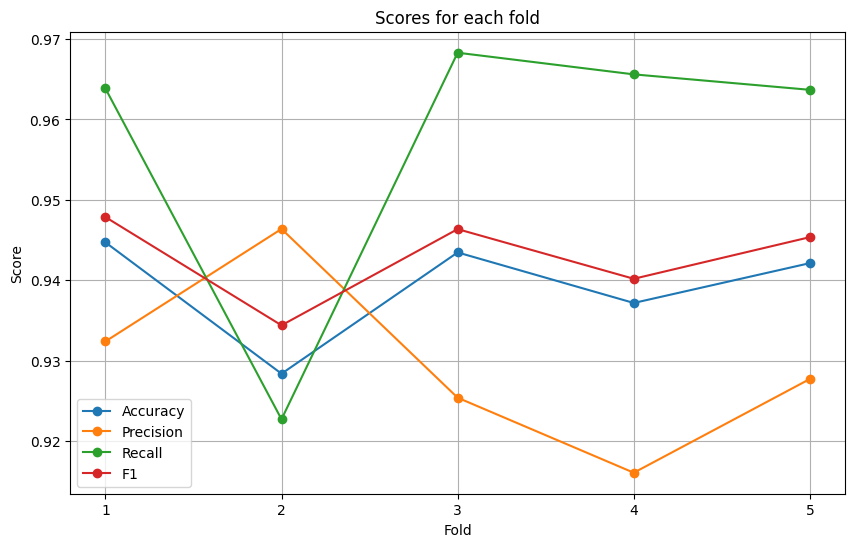

In [7]:
# Tạo mảng chứa số fold
folds = range(1, len(accuracy_list) + 1)

# Định dạng plot
plt.figure(figsize=(10, 6))

# Vẽ đường kết quả cho từng fold
plt.plot(folds, accuracy_list, marker='o', label='Accuracy')
plt.plot(folds, precision_list, marker='o', label='Precision')
plt.plot(folds, recall_list, marker='o', label='Recall')
plt.plot(folds, f1_list, marker='o', label='F1')

# Chú thích và nhãn
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Scores for each fold')
plt.xticks(folds)
plt.legend()
plt.grid(True)

# Hiển thị plot
plt.show()

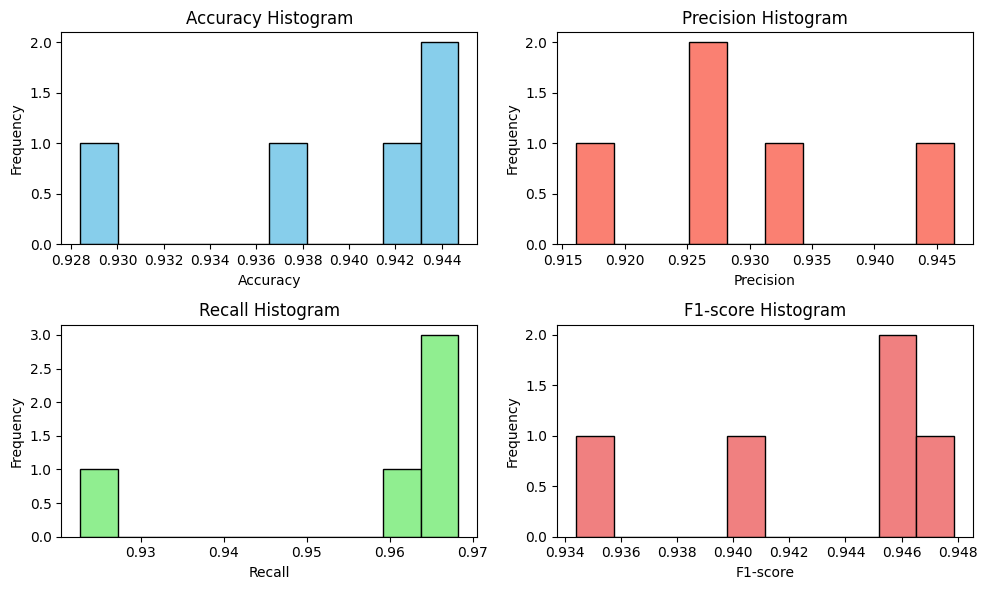

In [8]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.hist(accuracy_list, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Histogram')

plt.subplot(2, 2, 2)
plt.hist(precision_list, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Precision')
plt.ylabel('Frequency')
plt.title('Precision Histogram')

plt.subplot(2, 2, 3)
plt.hist(recall_list, bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.title('Recall Histogram')

plt.subplot(2, 2, 4)
plt.hist(f1_list, bins=10, color='lightcoral', edgecolor='black')
plt.xlabel('F1-score')
plt.ylabel('Frequency')
plt.title('F1-score Histogram')

plt.tight_layout()
plt.show()

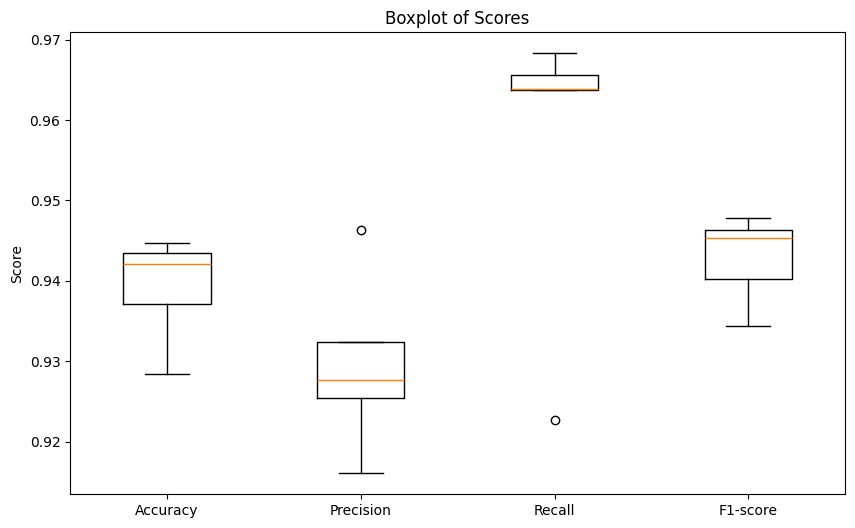

In [9]:
plt.figure(figsize=(10, 6))

plt.boxplot([accuracy_list, precision_list, recall_list, f1_list], labels=['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylabel('Score')
plt.title('Boxplot of Scores')

plt.show()

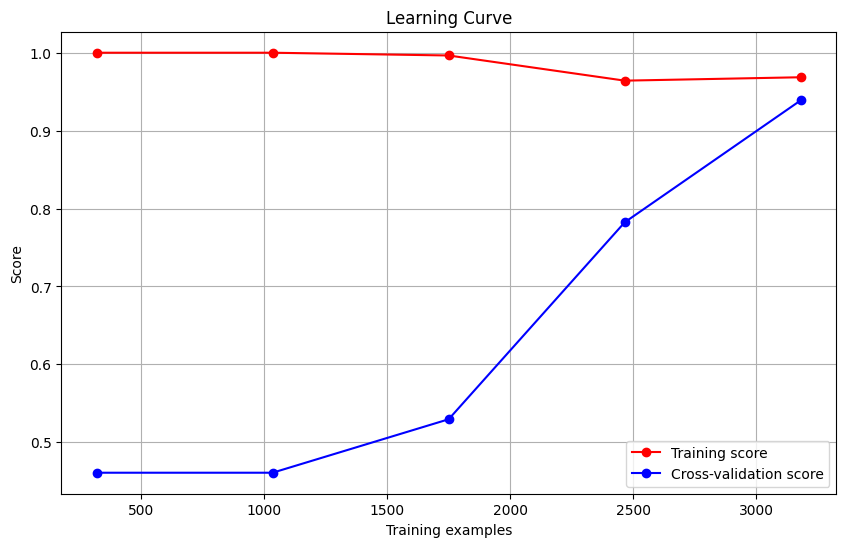

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error", "error@0.6"]),
    X=x, y=y,
    train_sizes=np.linspace(.1, 1.0, 5),
    cv=skf,
    scoring='accuracy',  # or any other scoring metric you want to use
    n_jobs=-1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='b', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

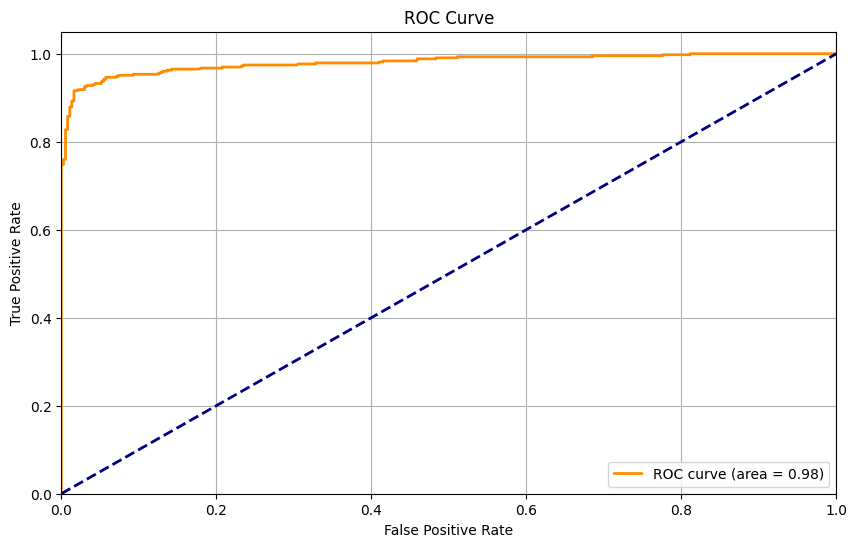

In [11]:
from sklearn.metrics import roc_curve, auc

# Fit model
xgboost_model = XGBClassifier(objective="binary:logistic", n_estimators=20, random_state=42, eval_metric=["auc", "error", "error@0.6"])
xgboost_model.fit(x_train, y_train)

# Predict probabilities
y_prob = xgboost_model.predict_proba(x_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
